# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
training_file = '/home/nik/Documents/SDC/Udacity_SDC_Nanodegree_Projects/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/train.p'
validation_file = '/home/nik/Documents/SDC/Udacity_SDC_Nanodegree_Projects/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/valid.p'
testing_file = '/home/nik/Documents/SDC/Udacity_SDC_Nanodegree_Projects/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = (len(set(y_train)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled files

3


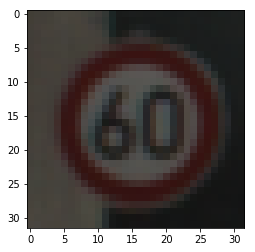

In [3]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
import random
%matplotlib inline

index = random.randint(0,len(X_train))
image = X_train[index]
plt.imshow(image)
print(y_train[index])

### Plot histogram of the Training Data

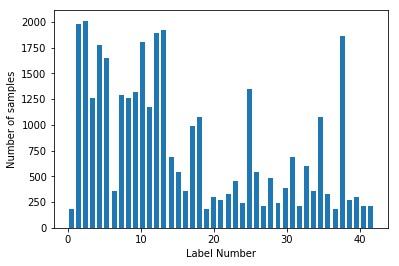

In [4]:
# I plot a histogram of samples so that I know how many images of each label in the training set

import numpy as np
hist, bins = np.histogram(y_train, n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Label Number')
plt.ylabel('Number of samples')
plt.show()

### Data Augmentation

- The histogram shows that the number of examples for each classes is not uniform. So I decided to generate examples for the classes that are under-represented (i.e. classes where number of images < average number of images).
- To create the extra images, I augmented the existing images by either rotation, blurring, scaling, or translating images

In [5]:
from scipy import ndimage
import random
import numpy as np
import cv2
from sklearn.utils import shuffle

# To create the extra images, I augmented the existing images by either rotation, blurring, scaling, or translating images
def augmented_image(X_train, index_numbers,example_in_class):
    random_number = random.randint(0,1)
    img = X_train[index_numbers][random.randint(0,example_in_class - 1)]
    if random_number == 0:
        return ndimage.rotate(img, random.choice(angles), reshape=False)
    elif random_number == 1:
        return cv2.GaussianBlur(img,(5,5),0)  
    elif random_number == 2:
        return cv2.resize(img,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    elif random_number == 3:
        M = np.float32([[1,0,2],[0,1,2]])
        return cv2.warpAffine(img,M,(cols,rows))

examples_in_class = np.bincount(y_train)
mean_examples = int(np.mean(examples_in_class))
# Angles by which the image is to be rotated
angles = [-10, 10, -15, 15, -20, 20]

images,values = [],[]

for i in range(len(examples_in_class)):    
    if examples_in_class[i] < mean_examples:
        # The number of extra images needed
        extra_images_needed = mean_examples - examples_in_class[i]
        # The intex number of all images  of this class
        index_numbers = np.where(y_train == i)

        # Generate all new images needed
        new_x, new_y = [], []
        for j in range(extra_images_needed):
            temp_image = augmented_image(X_train, index_numbers,examples_in_class[i]) #ndimage.rotate(X_train[index_numbers][random.randint(0,examples_in_class[i] - 1)], random.choice(angles), reshape=False)
            new_x.append(temp_image)
            new_y.append(i)

        # Add the new images to training set
        X_train = np.append(X_train, np.array(new_x), axis=0)
        y_train = np.append(y_train, np.array(new_y), axis=0)

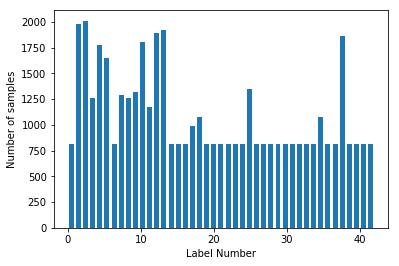

In [6]:
# Plot the histogram again to make sure the ditribution is a little more uniform

import numpy as np
hist, bins = np.histogram(y_train, n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Label Number')
plt.ylabel('Number of samples')
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

The image data should be normalized so that the data has mean zero and equal variance. Empirically, it looks like converting to grayscale improves the accuracy.

In [7]:
from sklearn.utils import shuffle

X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_normalized_train = np.array((X_train_gray-128)/128)
X_normalized_train, y_train = shuffle(X_normalized_train, y_train)

X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
X_normalized_valid = (X_valid_gray - 128)/128

X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)
X_normalized_test = (X_test_gray - 128)/128

X_train = X_normalized_train
X_valid = X_normalized_valid
X_test = X_normalized_test

### Model Architecture

In [8]:
import tensorflow as tf
import cv2
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

def CNN(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.tanh(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.tanh(conv2)
    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # Input = 800. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.tanh(fc1)

    # Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.tanh(fc2)

    # Input = 120. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
# Using a place holder
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
# One hot Encoding
one_hot_y = tf.one_hot(y, n_classes)

logits = CNN(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
training_operation = optimizer.minimize(loss_operation)

# What is a correct prediction, and how to calculate accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define saver to be able to save the data
saver = tf.train.Saver()

In [10]:
# Evaluation function. This will be called after every epoch
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
# Finally, train the model and save the weights

# The number of epochs is chosen empirically
# The batch size is limited by the RAM
epochs = 10
batch_size = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'traffic_sign_classification')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.909

EPOCH 2 ...
Validation Accuracy = 0.942

EPOCH 3 ...
Validation Accuracy = 0.952

EPOCH 4 ...
Validation Accuracy = 0.951

EPOCH 5 ...
Validation Accuracy = 0.958

EPOCH 6 ...
Validation Accuracy = 0.957

EPOCH 7 ...
Validation Accuracy = 0.959

EPOCH 8 ...
Validation Accuracy = 0.950

EPOCH 9 ...
Validation Accuracy = 0.957

EPOCH 10 ...
Validation Accuracy = 0.961

Model saved


In [12]:
# Test the model with the test set 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./traffic_sign_classification.meta')
    saver2.restore(sess, "./traffic_sign_classification")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.933


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

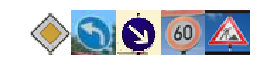

In [13]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(1,5, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./my_traffic_signs/*')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_labels = [12,34,38,3,25]

### Predict the Sign Type for Each Image

In [14]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

my_images = np.asarray(my_images)
my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)
my_images_normalized = (my_images_gry - 128)/128 
prediction_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./traffic_sign_classification.meta')
    saver3.restore(sess, "./traffic_sign_classification")
    
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("My Test Set Accuracy = {:.3f}".format(my_accuracy))


My Test Set Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [17]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver4 = tf.train.import_meta_graph('./traffic_sign_classification.meta')
    saver4.restore(sess, "./traffic_sign_classification")
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized})

print(my_top_k)


#     predictions = sess.run(logits,feed_dict={x: my_images_normalized})
#     for prediction in predictions:
#         prediction = np.ndarray.tolist(prediction)
#         prediction_list.append(prediction.index(min(prediction)))

# print(prediction_list)


TopKV2(values=array([[  9.99950886e-01,   3.74696283e-05,   5.20993990e-06,
          2.73601745e-06,   1.02220633e-06],
       [  9.97738242e-01,   9.71153670e-04,   8.21605092e-04,
          1.63490447e-04,   7.31774417e-05],
       [  9.99820411e-01,   4.99690650e-05,   2.98443792e-05,
          2.83869522e-05,   1.26166751e-05],
       [  9.96951461e-01,   1.22697768e-03,   8.38581414e-04,
          1.96508699e-04,   1.17200339e-04],
       [  5.23354173e-01,   3.30063701e-01,   9.72659141e-02,
          2.23752763e-02,   6.63781539e-03]], dtype=float32), indices=array([[12, 40,  9, 15, 32],
       [34, 36, 38, 28,  3],
       [38, 36, 14, 34, 23],
       [ 3, 23, 20, 16, 11],
       [31, 37, 25, 20,  0]], dtype=int32))
